# Add injury to insult
#### A case study of murdering someone with the right choice of words

### Attacker
Nyah, level 5 witch (The Resentment)
**Skills** Diplomacy +14 (Bon Mot)

**Occult Spells** DC 21; **3rd** Blindness, Biting Words; **2nd** Blistering Invective; **1st** Sure Strike x3 ; **Cantrips (3rd)** Evil Eye

### Attack routine
1. Bon Mot, Blistering Invective
2. Blindness, Evil Eye
3. Evil Eye or Sure Strike, Biting Words
4. Evil Eye, Sure Strike, Biting Words attack
5. Evil Eye, Sure Strike, Biting Words attack

### Assumptions
- The target attempts to clear neither Bon Mot nor Sickened
- No movement is needed; the target remains within 30ft at all time
- Spellcasting is not disrupted or obstructed in any way
- Ignoring damage dealt to other creatures by casting heightened blistering invective

In [1]:
import numpy as np
import xarray
from pathfinder2e_stats import *

np.random.seed(0)

diplomacy = 14
spell_DC = 21

# You can change any of these to upcast or downcast them;
# damage and incapacitation trait are adjusted automatically
blistering_invective_rank = 2
blindness_rank = 3
biting_words_rank = 3

## Targets

In [2]:
targets = xarray.Dataset(
    {
        "target": [
            "The Stag Lord",
            "Ettin",
            "Vampire Count",
            "Hill Giant",
            "Dweomercat",
            "Sphinx",
        ],
        "level": ("target", [6, 6, 6, 7, 7, 8]),
        "HP": ("target", [110, 110, 65, 140, 100, 135]),
        "AC": ("target", [23, 21, 24, 24, 25, 27]),
        "Will": ("target", [9, 12, 17, 13, 17, 19]),
        "bonus_save_vs_magic": ("target", [0, 0, 0, 0, 1, 0]),
        "sickened": ("target", [1, 0, 0, 0, 0, 0]),
    }
)
targets["rank"] = level2rank(targets.level)
targets.to_pandas()

,level,HP,AC,Will,bonus_save_vs_magic,sickened,rank
target,,,,,,,
The Stag Lord,6,110,23,9,0,1,3
Ettin,6,110,21,12,0,0,3
Vampire Count,6,65,24,17,0,0,3
Hill Giant,7,140,24,13,0,0,4
Dweomercat,7,100,25,17,1,0,4
Sphinx,8,135,27,19,0,0,4


## Round 1: Bon Mot -> Blistering Invective

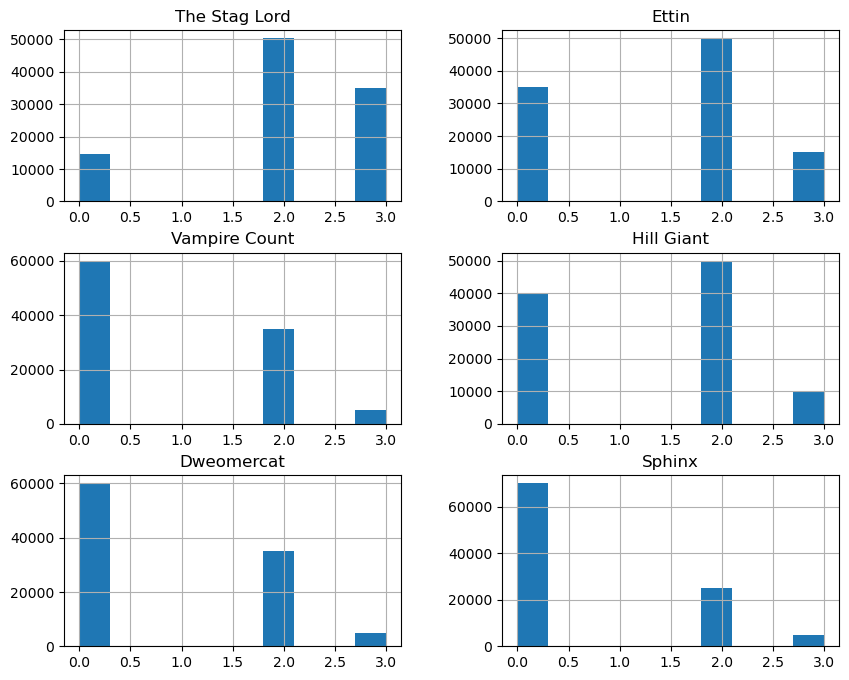

In [3]:
bon_mot = check(diplomacy, DC=targets.Will + 10 - targets.sickened)
bon_mot["Will_penalty"] = xarray.where(
    bon_mot.outcome == DoS.critical_success, 3,
    xarray.where(bon_mot.outcome == DoS.success, 2, 0)
)
_ = bon_mot.Will_penalty.to_pandas().hist(figsize=(10, 8))

In [4]:
sickened = [
    targets.sickened
]
will = [
    sum_bonuses(
        ("untyped", targets.Will),
        ("status", targets.bonus_save_vs_magic),
        ("status", -targets.sickened),
        ("status", -bon_mot.Will_penalty),
    )
]

blistering_invective = damage(
    check(will[0], DC=spell_DC),
    Damage("fire", blistering_invective_rank // 2 * 2, 6, persistent=True, basic_save=True),
    persistent_damage_rounds=5
).rename({"persistent_round": "round"})

blistering_invective_damage = blistering_invective["persistent_damage"].where(
    blistering_invective["apply_persistent_damage"], 0
).sum("damage_type")
blistering_invective_damage.mean("roll").to_pandas().T

target,The Stag Lord,Ettin,Vampire Count,Hill Giant,Dweomercat,Sphinx
round,,,,,,
0,7.01174,5.18965,3.30539,4.85302,2.96167,2.54133
1,4.90901,3.64111,2.31008,3.40304,2.07076,1.77410
2,3.41427,2.53463,1.61399,2.36940,1.44693,1.23803
3,2.41098,1.78437,1.13354,1.66736,1.01670,0.87056
4,1.69569,1.25273,0.80113,1.17292,0.71689,0.61383


In [5]:
frightened = map_outcome(
    blistering_invective["outcome"],
    {DoS.failure: 1, DoS.critical_failure: 2},
)
frightened = np.maximum(0, frightened - blistering_invective["round"])
frightened.isel(roll=3).to_pandas()

round,0,1,2,3,4
target,,,,,
The Stag Lord,2,1,0,0,0
Ettin,1,0,0,0,0
Vampire Count,0,0,0,0,0
Hill Giant,1,0,0,0,0
Dweomercat,0,0,0,0,0
Sphinx,0,0,0,0,0


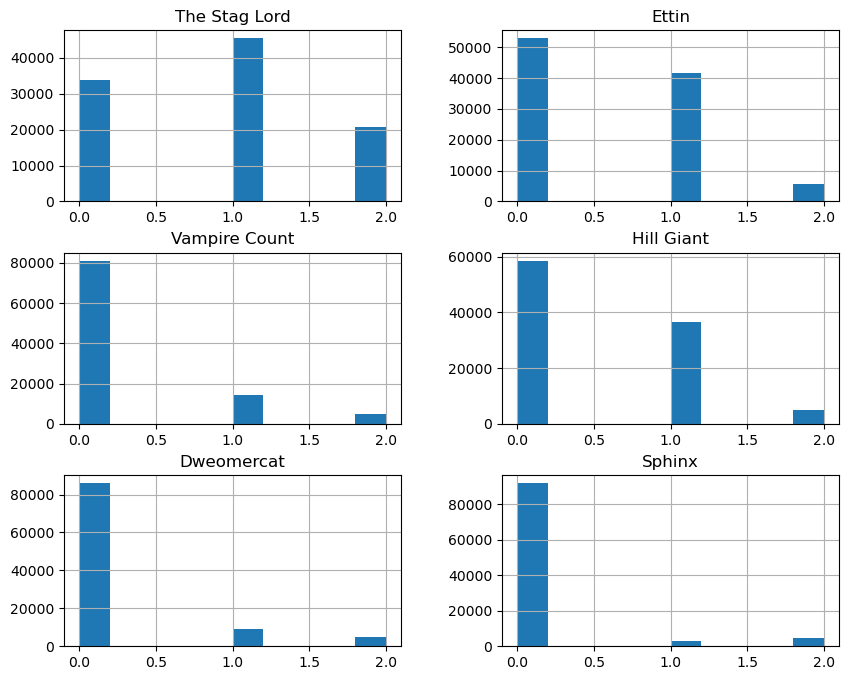

In [6]:
_ = frightened.isel(round=0).to_pandas().hist(figsize=(10, 8))

## Round 2: Blindness -> Evil Eye
Blindness is a rank 3+ spell with the incapacitation trait. level 7+ targets get the success of their saves one step better. Evil Eye is used to extend the duration.

In [7]:
will.append(
    sum_bonuses(
        ("untyped", targets.Will),
        ("status", targets.bonus_save_vs_magic),
        ("status", -sickened[-1]),
        ("status", -bon_mot.Will_penalty),
        ("status", -frightened.isel(round=1, drop=True)),
    )
)
blindness = check(
    bonus=will[-1],
    DC=spell_DC,
    incapacitation=targets["rank"] > blindness_rank,
)

# In case of simple success, we use Evil Eye to extend the blindness for the whole combat
blindness["need_evil_eye"] = blindness.outcome == DoS.success
blindness["blind"] = blindness.outcome < DoS.critical_success
blindness

<xarray.Dataset> Size: 16MB
Dimensions:           (target: 6, roll: 100000)
Coordinates:
  * target            (target) <U13 312B 'The Stag Lord' 'Ettin' ... 'Sphinx'
Dimensions without coordinates: roll
Data variables:
    bonus             (target, roll) int64 5MB 7 6 8 7 7 7 ... 19 19 18 18 19 19
    DC                int64 8B 21
    natural           (roll) int64 800kB 11 16 9 15 9 14 16 ... 5 7 19 11 19 2
    original_outcome  (roll, target) int64 5MB 0 1 1 1 1 1 1 ... 2 -1 0 0 0 0 1
    outcome           (roll, target) int64 5MB 0 1 1 2 2 2 1 ... 2 -1 0 0 1 1 2
    need_evil_eye     (roll, target) bool 600kB False True True ... True False
    blind             (roll, target) bool 600kB True True True ... True False
Attributes:
    keen:            False
    incapacitation:  varies
    fortune:         False
    misfortune:      False
    hero_point:      False
    legend:          {-2: 'No roll', -1: 'Critical failure', 0: 'Failure', 1:...

In [8]:
blindness[["blind", "need_evil_eye"]].mean("roll").to_pandas()

,blind,need_evil_eye
target,,
The Stag Lord,0.95098,0.29463
Ettin,0.93360,0.46124
Vampire Count,0.69019,0.49662
Hill Giant,0.41596,0.36478
Dweomercat,0.14335,0.09217
Sphinx,0.08408,0.03290


In [9]:
def evil_eye(will_bonus, spell_DC, do_cast=True):
    c = check(will_bonus, DC=spell_DC).outcome
    c = c.where(do_cast, DoS.no_roll)
    return map_outcome(c, {DoS.critical_failure: 2, DoS.failure: 1})


sickened.append(
    np.maximum(sickened[-1], evil_eye(will[-1], spell_DC))
)

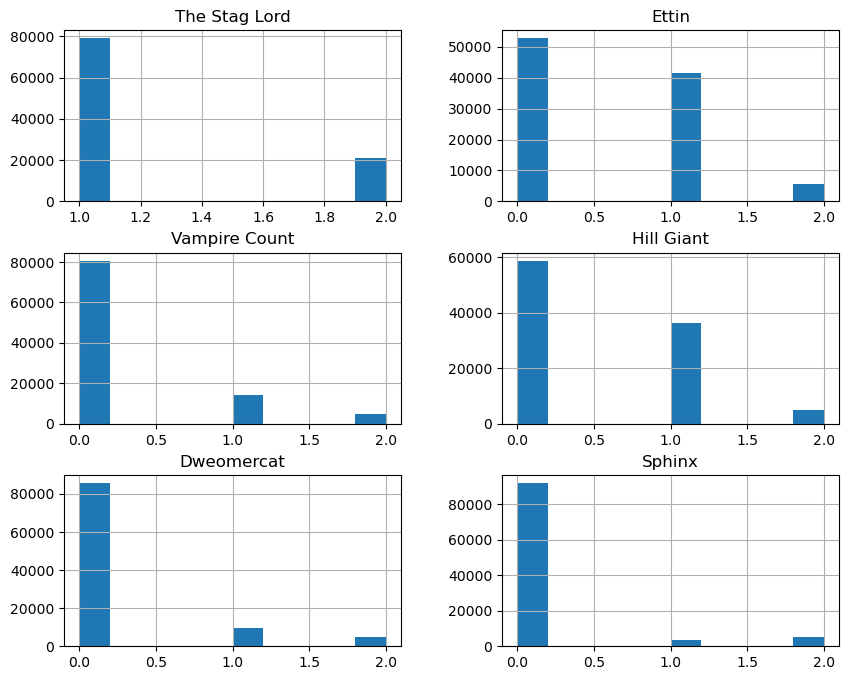

In [10]:
_ = sickened[-1].to_pandas().T.hist(figsize=(10, 8))

### Round 3: Evil Eye or Sure Strike -> Biting Words
If the target scored a simple success vs. Blindness in round 2, extend its duration with Evil Eye.
Otherwise, cast Sure Strike. Then, cast Biting Words.
### Round 4 and 5: Evil Eye -> Sure Strike -> Biting Words attack

In [11]:
for rnd in range(2, 5):
    will.append(
        sum_bonuses(
            ("untyped", targets.Will),
            ("status", targets.bonus_save_vs_magic),
            ("status", -sickened[-1]),
            ("status", -bon_mot.Will_penalty),
        )
    )
    cast_evil_eye = blindness.need_evil_eye if rnd == 2 else True
    sickened.append(
        np.maximum(
            sickened[-1],
            evil_eye(will[-1], spell_DC, do_cast=cast_evil_eye)
        )
    )

assert len(will) == 5
assert len(sickened) == 5

will = xarray.concat(will, dim="round")
sickened = xarray.concat(sickened, dim="round")

In [12]:
off_guard = xarray.concat(
    [
        xarray.DataArray(False),
        blindness.blind.expand_dims(round=4),
    ],
    dim="round"
)
AC = sum_bonuses(
    ("untyped", targets.AC),
    ("status", -frightened),
    ("status", -sickened),
    ("circumstance", off_guard.astype(int) * -2),
)
AC.mean("roll").to_pandas()

round,0,1,2,3,4
target,,,,,
The Stag Lord,21.79318,19.88816,19.84044,19.68592,19.56538
Ettin,20.47169,18.57397,18.46445,18.21891,18.06882
Vampire Count,23.76127,22.33777,22.27574,22.09357,21.94039
Hill Giant,23.53667,22.67657,22.59829,22.34982,22.18642
Dweomercat,24.81050,24.47873,24.50295,24.33984,24.19750
Sphinx,26.87037,26.65522,26.69261,26.57403,26.46516


In [13]:
# TODO allow check(... fortune=...) with DataArray parameter
biting_words_check = check(spell_DC - 10, DC=AC, dims={"fortune": 2})
biting_words_check["outcome"] = xarray.concat(
    [
        xarray.DataArray([DoS.no_roll, DoS.no_roll], dims=["round"]),
        xarray.where(
            blindness.need_evil_eye,
            biting_words_check["outcome"].isel(round=2, fortune=0),
            biting_words_check["outcome"].isel(round=2).max("fortune"),
        ),
        biting_words_check["outcome"].isel(round=[3, 4]).max("fortune"),
    ],
    dim="round",
)

biting_words_damage = damage(
    biting_words_check,
    Damage("sonic", biting_words_rank * 2, 6)
).total_damage
biting_words_damage.mean("roll").T.to_pandas()

round,0,1,2,3,4
target,,,,,
The Stag Lord,0.0,0.0,19.99095,22.49152,22.78601
Ettin,0.0,0.0,21.92141,26.06616,26.41545
Vampire Count,0.0,0.0,14.42783,17.80688,18.02297
Hill Giant,0.0,0.0,14.85656,17.45410,17.67148
Dweomercat,0.0,0.0,14.26647,15.01826,15.19266
Sphinx,0.0,0.0,11.50572,11.87006,12.04271


In [14]:
final = xarray.Dataset(
    {
        "AC": AC,
        "Will": will,
        "blind": blindness.blind,
        "need_evil_eye": blindness.need_evil_eye,
        "blistering_invective": blistering_invective_damage,
        "biting_words": biting_words_damage,
        "total_damage": blistering_invective_damage + biting_words_damage,
    }
).transpose("target", "roll", "round")
final["harmed"] = final.total_damage.sum("round") > 0
final["bloodied"] = final.total_damage.sum("round") > targets.HP // 2
final["killed"] = final.total_damage.sum("round") >= targets.HP
final

<xarray.Dataset> Size: 123MB
Dimensions:               (target: 6, roll: 100000, round: 5)
Coordinates:
  * target                (target) <U13 312B 'The Stag Lord' ... 'Sphinx'
Dimensions without coordinates: roll, round
Data variables:
    AC                    (target, roll, round) int64 24MB 22 20 20 ... 27 27 27
    Will                  (target, roll, round) int64 24MB 7 7 7 7 ... 19 19 19
    blind                 (target, roll) bool 600kB True True ... False False
    need_evil_eye         (target, roll) bool 600kB False True ... False False
    blistering_invective  (target, roll, round) int64 24MB 8 0 0 0 0 ... 0 0 0 0
    biting_words          (target, roll, round) int64 24MB 0 0 21 21 ... 0 0 0 0
    total_damage          (target, roll, round) int64 24MB 8 0 21 21 ... 0 0 0 0
    harmed                (target, roll) bool 600kB True True ... False True
    bloodied              (target, roll) bool 600kB True True ... False False
    killed                (target, roll) bool 600kB False False ... False False

In [15]:
# Mean cumulative damage by the end of the attack routine
final.mean("roll").sum("round")[["blistering_invective", "biting_words", "total_damage"]].to_pandas()

,blistering_invective,biting_words,total_damage
target,,,
The Stag Lord,19.44169,65.26848,84.71017
Ettin,14.40249,74.40302,88.80551
Vampire Count,9.16413,50.25768,59.42181
Hill Giant,13.46574,49.98214,63.44788
Dweomercat,8.21295,44.47739,52.69034
Sphinx,7.03785,35.41849,42.45634


In [16]:
# Mean damage, by round
final.mean("roll")["total_damage"].to_pandas()

round,0,1,2,3,4
target,,,,,
The Stag Lord,7.01174,4.90901,23.40522,24.90250,24.48170
Ettin,5.18965,3.64111,24.45604,27.85053,27.66818
Vampire Count,3.30539,2.31008,16.04182,18.94042,18.82410
Hill Giant,4.85302,3.40304,17.22596,19.12146,18.84440
Dweomercat,2.96167,2.07076,15.71340,16.03496,15.90955
Sphinx,2.54133,1.77410,12.74375,12.74062,12.65654


- Probability of dealing any HP damage at all
- Probability of dealing more than 50% HP damage
- Probability of solo killing the target
- Probability of blinding the target in round 2
- Probability of needing to spam evil eye every round to keep them blind

In [17]:
final[["harmed", "bloodied", "killed", "blind", "need_evil_eye"]].mean("roll").to_pandas()

,harmed,bloodied,killed,blind,need_evil_eye
target,,,,,
The Stag Lord,0.99251,0.79197,0.24701,0.95098,0.29463
Ettin,0.99324,0.81581,0.29173,0.93360,0.46124
Vampire Count,0.92316,0.74907,0.46318,0.69019,0.49662
Hill Giant,0.97627,0.43970,0.04492,0.41596,0.36478
Dweomercat,0.86597,0.56551,0.11240,0.14335,0.09217
Sphinx,0.77999,0.29185,0.04826,0.08408,0.03290


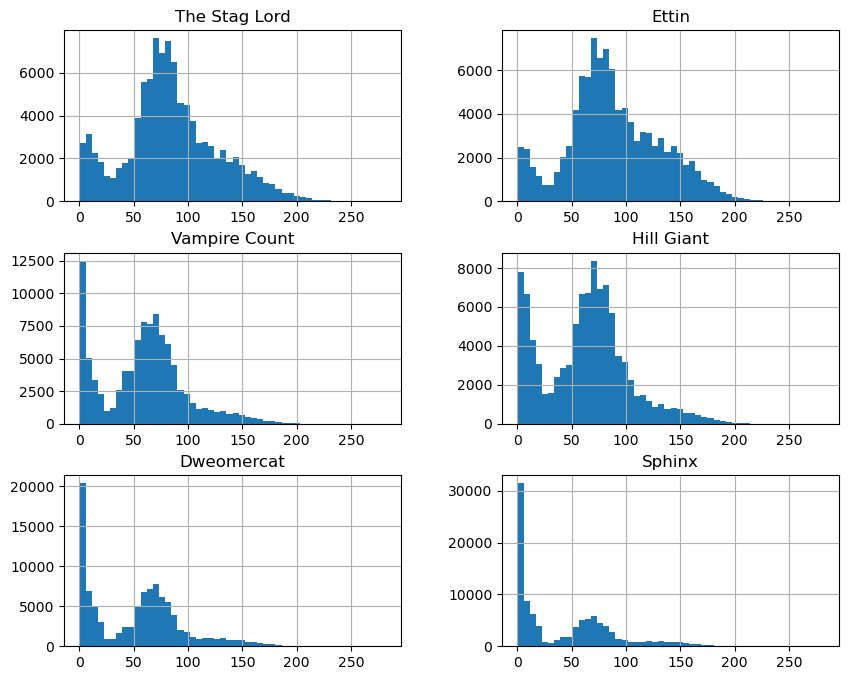

In [18]:
# Damage distribution
_ = final["total_damage"].sum("round").T.to_pandas().hist(bins=50, figsize=(10, 8))

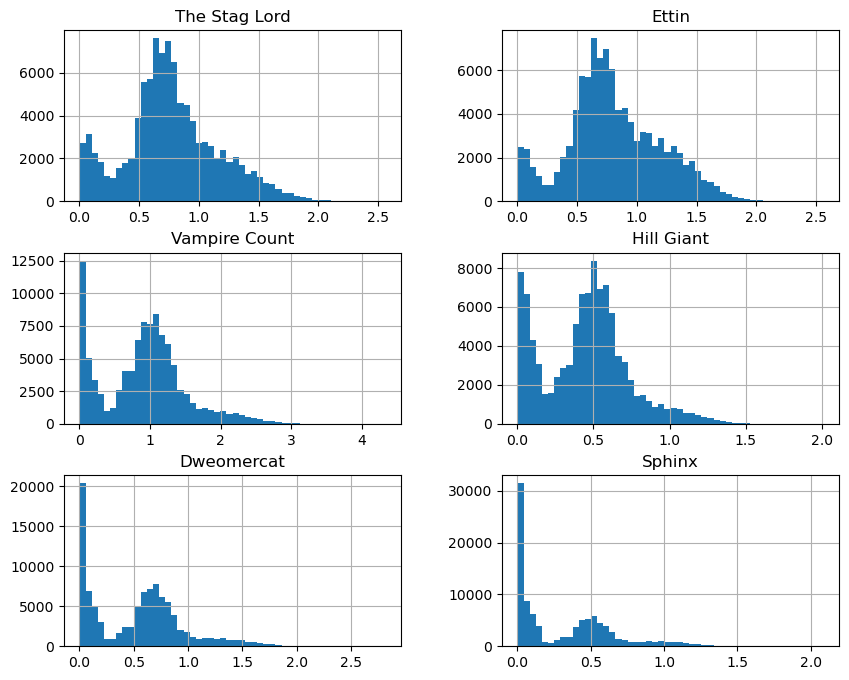

In [19]:
# Damage distribution, normalized by target's hit points total
_ = (final["total_damage"].sum("round") / targets.HP).T.to_pandas().hist(bins=50, figsize=(10, 8))

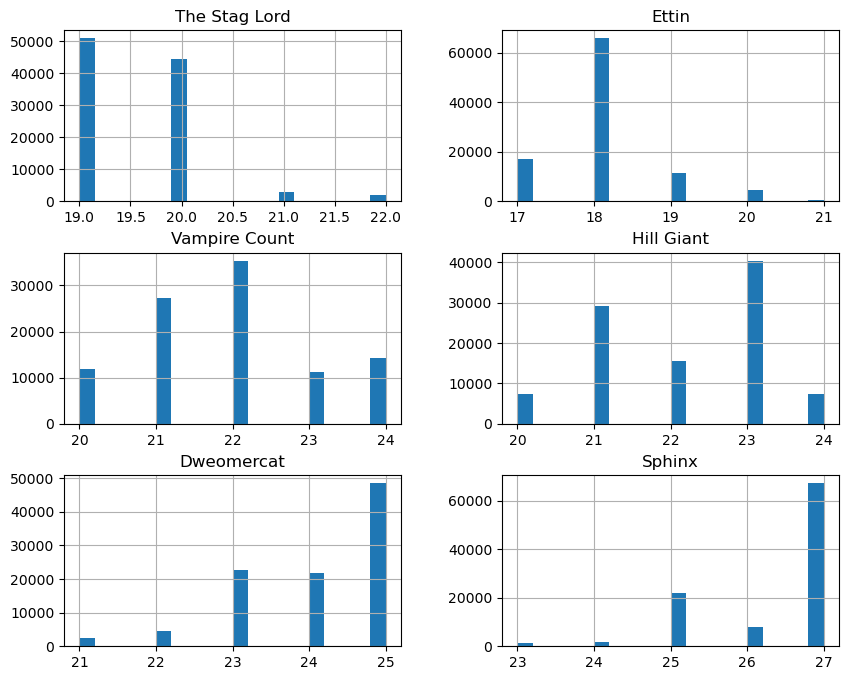

In [20]:
# Worst AC over the 5 rounds
_ = final.min("round")["AC"].T.to_pandas().hist(bins=20, figsize=(10, 8))

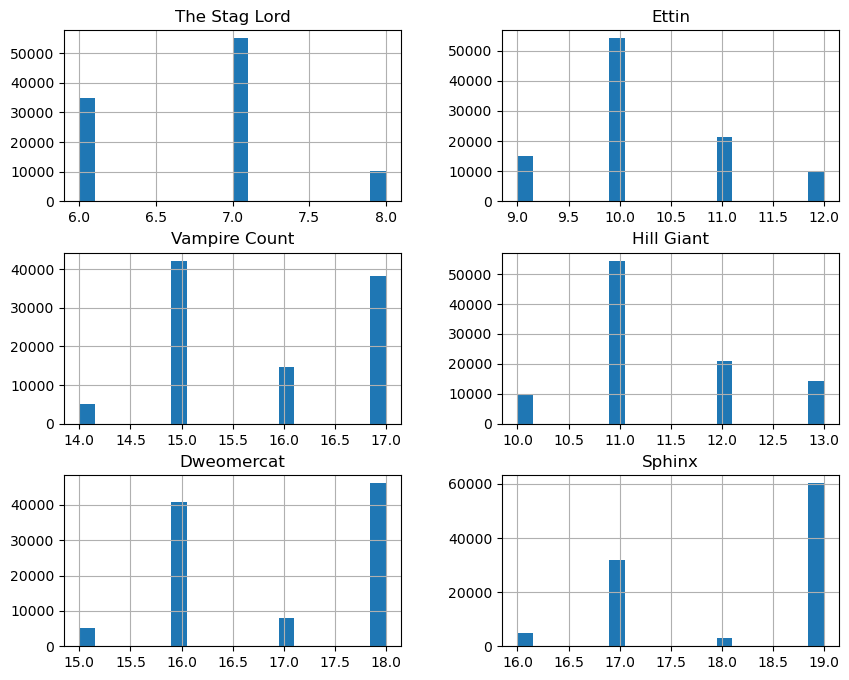

In [21]:
# Worst Will bonus over the 5 rounds
_ = final.min("round")["Will"].T.to_pandas().hist(bins=20, figsize=(10, 8))